## Excercise 4 - **Introduction to distributed parallelization**

The goal of this exercise is to:
- understand the basic idea of distributed parallelization;
- and learn about [ImplicitGlobalGrid.jl](https://github.com/eth-cscs/ImplicitGlobalGrid.jl) and [ParallelStencil.jl](https://github.com/omlins/ParallelStencil.jl) on the way.

[*This content is distributed under BSD 3-Clause License. Authors: S. Omlin (CSCS, ETH Zurich).*](https://github.com/omlins/julia-gpu-course-2025/blob/main/LICENSE.md)

In this notebook, we aim to get a good understanding of the concept of distributed computing. We want to focus on the understanding rather than the implementation and will, therefore, illustrate the essence of distributed computing with some single process examples; then, we will explore it further with [ImplicitGlobalGrid.jl](https://github.com/eth-cscs/ImplicitGlobalGrid.jl), which makes it almost trivial. ImplicitGlobalGrid.jl will enable our stencil-computation-based codes to run on multiple GPUs and CPUs in order to scale on modern multi-GPUs/CPU nodes, clusters and supercomputers. ImplicitGlobalGrid.jl implements the required inter-process communication using (GPU-aware) MPI. Each process handles one GPU or CPU (or CPU core).

We will now use the packages `ParallelStencil` and `Plots` (we will not use `ImplicitGlobalGrid` within the notebook as it requires MPI which is not always available in Jupyter services):

In [1]:
] activate .

  Activating project at `~/tmpwdir/julia-gpu-course-2025/solutions`


In [2]:
using Plots
using ParallelStencil
using ParallelStencil.FiniteDifferences2D
@init_parallel_stencil(CUDA, Float64, 3) # or initialize with Threads, AMDGPU or Metal instead of CUDA


Let us consider the same 2-D heat diffusion solver as in the last part of the first *Data transfer optimisation notebook* (`2_datatransfer_optimisations.ipynb`):

[ Info: Saved animation to /users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif


Plots.AnimatedGif("/users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif")
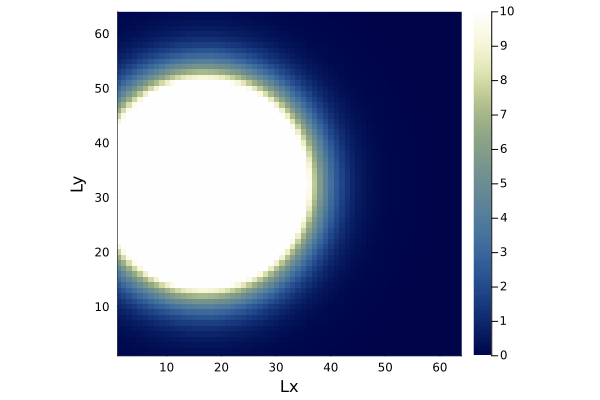

In [3]:
function diffusion2D()
    # Physics
    lam      = 1.0                                          # Thermal conductivity
    c0       = 2.0                                          # Heat capacity
    lx, ly   = 10.0, 10.0                                   # Length of computational domain in dimension x and y

    # Numerics
    nx, ny   = 32*2, 32*2                                   # Number of gridpoints in dimensions x and y
    nt       = 100                                          # Number of time steps
    dx       = lx/(nx-1)                                    # Space step in x-dimension
    dy       = ly/(ny-1)                                    # Space step in y-dimension

    # Array initializations
    T    = @zeros(nx, ny)                                   # Temperature
    T2   = @zeros(nx, ny)                                   # 2nd array for Temperature
    Ci   = @zeros(nx, ny)                                   # 1/Heat capacity

    # Initial conditions
    Ci .= 1/c0                                              # 1/Heat capacity (could vary in space)
    T  .= Data.Array([100.0*exp(-(((ix-1)*dx-lx/4)/2)^2-(((iy-1)*dy-ly/2)/2)^2) for ix=1:size(T,1), iy=1:size(T,2)]) # Initialization of Gaussian temperature anomaly
    T2 .= T;                                                # Assign also T2 to get correct boundary conditions.

    # Time loop
    dt  = min(dx^2,dy^2)/lam/maximum(Ci)/4.1                # Time step for 2D Heat diffusion
    opts = (aspect_ratio=1, xlims=(1, nx), ylims=(1, ny), clims=(0.0, 10.0), c=:davos, xlabel="Lx", ylabel="Ly") # plotting options
    @gif for it = 1:nt
        @parallel diffusion2D_step!(T2, T, Ci, lam, dt, dx, dy)  # Diffusion time step.
        heatmap(Array(T)'; opts...)
        T, T2 = T2, T                                       # Swap the aliases T and T2 (does not perform any array copy)
    end
end

@parallel function diffusion2D_step!(T2, T, Ci, lam, dt, dx, dy)
    @inn(T2) = @inn(T) + dt*(lam*@inn(Ci)*(@d2_xi(T)/dx^2 + @d2_yi(T)/dy^2));
    return
end

diffusion2D()

### Task 1 (periodic boundaries using halo)

Distributed parallelization requires, in general, inter-process communication in order to produce correct results. Depending on the class of application, different communication patterns arise. Stencil-based applications are normally parallelized by decomposing the computational domain into multiple local problems where each process takes care of one of them. The processes are organized themselves in a topology that corresponds to topology of the local problems. In order to connect the local problems and have them form correctly the global problem, each process needs to receive from the neighboring processes the values of the boundaries of the local problem. In modelers' words, the boundary conditions of the local problems are defined by the processes that take care of the adjacent local problems. The following schema illustrates this in 2D:

![implicit_global_grid.png](./figures/implicit_global_grid.png)

Note that the local problem boundaries that are defined by the adjacent processes are called "halos" and the communication described above is called "halo updates".

The concept of halo updates can be understood without having to be exposed to the full complexity of distributed parallelization: in a single process application, periodic boundaries can be implemented using halo updates. The following schema illustrates this in 2D:

![periodic_boundaries.png](./figures/periodic_boundaries.png)

The code below is identical to the one above, except that it contains now a call to `update_halo_periodx!`. Run the code and look at the visualization; then implement the function `update_halo_periodx!` in order to perform halo updates that will result in periodicity in x-dimension. Then, run the code again and note what has changed in the visualization.

In [4]:
function diffusion2D()
    # Physics
    lam      = 1.0                                          # Thermal conductivity
    c0       = 2.0                                          # Heat capacity
    lx, ly   = 10.0, 10.0                                   # Length of computational domain in dimension x and y

    # Numerics
    nx, ny   = 32*2, 32*2                                   # Number of gridpoints in dimensions x and y
    nt       = 100                                          # Number of time steps
    dx       = lx/(nx-1)                                    # Space step in x-dimension
    dy       = ly/(ny-1)                                    # Space step in y-dimension

    # Array initializations
    T    = @zeros(nx, ny)                                   # Temperature
    T2   = @zeros(nx, ny)                                   # 2nd array for Temperature
    Ci   = @zeros(nx, ny)                                   # 1/Heat capacity

    # Initial conditions
    Ci .= 1/c0                                              # 1/Heat capacity (could vary in space)
    T  .= Data.Array([100.0*exp(-(((ix-1)*dx-lx/4)/2)^2-(((iy-1)*dy-ly/2)/2)^2) for ix=1:size(T,1), iy=1:size(T,2)]) # Initialization of Gaussian temperature anomaly
    T2 .= T;                                                # Assign also T2 to get correct boundary conditions.

    # Time loop
    dt  = min(dx^2,dy^2)/lam/maximum(Ci)/4.1                # Time step for 2D Heat diffusion
    opts = (aspect_ratio=1, xlims=(1, nx), ylims=(1, ny), clims=(0.0, 10.0), c=:davos, xlabel="Lx", ylabel="Ly") # plotting options
    @gif for it = 1:nt
        @parallel diffusion2D_step!(T2, T, Ci, lam, dt, dx, dy)  # Diffusion time step.
        update_halo_periodx!(T2)                                 # Update the halo of T2 locally such that we obtain periodic boundaries in x-dimension.
        heatmap(Array(T)'; opts...)
        T, T2 = T2, T                                       # Swap the aliases T and T2 (does not perform any array copy)
    end
end

diffusion2D (generic function with 1 method)

[ Info: Saved animation to /users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif


Plots.AnimatedGif("/users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif")
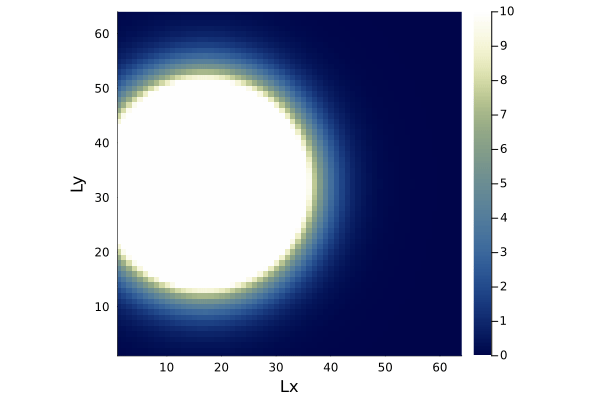

In [5]:
function update_halo_periodx!(A)
    A[  1,:] .= A[end-1,:]  # Copy the 2nd last row to the first row (halo)
    A[end,:] .= A[    2,:]  # Copy the 2nd row to the last row (halo)
    return
end

diffusion2D()


### Task 2 (periodic boundaries using halo - faster)

The function `update_halo_periodx!` calls now instead a kernel `kernel!` using ParallelStencil. Implement this kernel using `@parallel_indices`, taking into account that we will not launch a thread for each cell of array `A` but only for a subrange of it, which will map to the x-dimension halos that need to be updated (ranges argument `1:size(A,2)`). Run the code again and make sure that the visualization is identical as before.

[ Info: Saved animation to /users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif


Plots.AnimatedGif("/users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif")
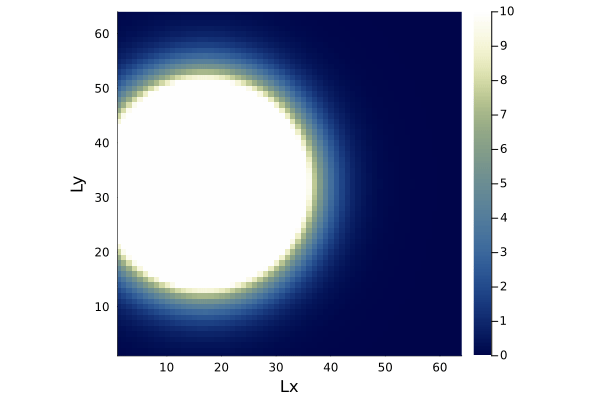

In [6]:
function update_halo_periodx!(A)
    @parallel (1:size(A,2)) kernel!(A)  # Call the kernel with the right ranges
    return
end

@parallel_indices (iy) function kernel!(A::Data.Array)
    A[  1, iy] = A[end-1, iy]  # Copy the 2nd last row to the first row (halo)
    A[end, iy] = A[    2, iy]  # Copy the 2nd row to the last row (halo)
    return
end

diffusion2D()

### Task 3 (hide communication)

For efficient scaling on supercomputers an important element is being able to hide communication between processes, e.g., halo updates, behind computation. In this example, we have only one process that "communicates" with itself. Nevertheless, we can also hide this "communication" in order to illustrate the concept. Therefore, use ParallelStencil's macro `@hide_communication` in order to overlap the computation with the halo update. Make sure that the simulation still produces the same result. The `@hide_communication` macro will automatically
1) split the computations (`@parallel` call) into boundary region computations and inner point computations,
2) launch both computations on different streams, and,
3) as soon as the boundary region computations have finished, launch the communication (here `update_halo_periodx!`). 

Note that the communication is only hideable if launched on a non-blocking stream. If that is not the case it will still produce correct results but will not overlap.

The macro `@hide_communication` takes two arguments
1) a tuple, indicating the width of the boundary regions in each dimension (the boundaries must include (at least) all the data that is accessed in the communcation performed);
2) a code block wich starts with one `@parallel` call to perform computations (for exceptions, see keyword `computation_calls`), followed by code to set boundary conditions and to perform communication (as e.g. update_halo! from the package ImplicitGlobalGrid).

More information can be obtained typing `?@hide_communication`. Here is an example for hiding communication in 3D using the macro:
```julia
@hide_communication (32, 2, 2) begin
    @parallel diffusion3D_step!(T2, Te Ci, lam, dt, dx, dy, dz);
    update_halo!(T2);
end
```
Note that in x-dimension we typically want to use a boundary regions with of 32 or at least 16 cells, in order to access the data also in the boundary regions computations in a contiguous fashion, leading to good performance.

[ Info: Saved animation to /users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif


Plots.AnimatedGif("/users/omlins/tmpwdir/julia-gpu-course-2025/solutions/tmp.gif")
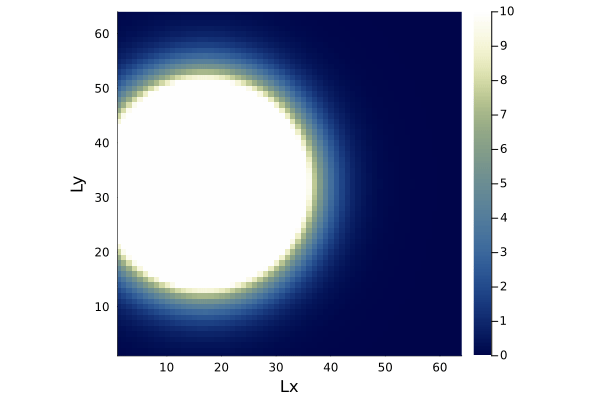

In [7]:
function diffusion2D()
    # Physics
    lam      = 1.0                                          # Thermal conductivity
    c0       = 2.0                                          # Heat capacity
    lx, ly   = 10.0, 10.0                                   # Length of computational domain in dimension x and y

    # Numerics
    nx, ny   = 32*2, 32*2                                   # Number of gridpoints in dimensions x and y
    nt       = 100                                          # Number of time steps
    dx       = lx/(nx-1)                                    # Space step in x-dimension
    dy       = ly/(ny-1)                                    # Space step in y-dimension

    # Array initializations
    T    = @zeros(nx, ny)                                   # Temperature
    T2   = @zeros(nx, ny)                                   # 2nd array for Temperature
    Ci   = @zeros(nx, ny)                                   # 1/Heat capacity

    # Initial conditions
    Ci .= 1/c0                                              # 1/Heat capacity (could vary in space)
    T  .= Data.Array([100.0*exp(-(((ix-1)*dx-lx/4)/2)^2-(((iy-1)*dy-ly/2)/2)^2) for ix=1:size(T,1), iy=1:size(T,2)]) # Initialization of Gaussian temperature anomaly
    T2 .= T;                                                # Assign also T2 to get correct boundary conditions.

    # Time loop
    dt  = min(dx^2,dy^2)/lam/maximum(Ci)/4.1                # Time step for 2D Heat diffusion
    opts = (aspect_ratio=1, xlims=(1, nx), ylims=(1, ny), clims=(0.0, 10.0), c=:davos, xlabel="Lx", ylabel="Ly") # plotting options
    @gif for it = 1:nt
        @hide_communication (16, 2) begin
            @parallel diffusion2D_step!(T2, T, Ci, lam, dt, dx, dy)  # Diffusion time step.
            update_halo_periodx!(T2)                                 # Update the halo of T2 locally such that we obtain periodic boundaries in x-dimension.
        end
        heatmap(Array(T)'; opts...)
        T, T2 = T2, T                                       # Swap the aliases T and T2 (does not perform any array copy)
    end
end

diffusion2D()

Successful hiding of communication behind computation can be verified, e.g., using Nvdia Nsigth Systems. Here is a screenshot showing overlap in a real world application using ParallelStencil and ImplicitGlobalGrid:
![overlap.png](./figures/overlap.png)

### Task 4 (multi-GPUs/CPU using ImplicitGlobalGrid)

Let us now consider the following multi-GPUs/CPU 3-D heat diffusion solver, which uses ImplicitGlobalGrid for distributed parallelization and ParallelStencil for parallelization within a GPU or CPU. The communication - calls to `update_halo!` - is hidden behind computation using ParallelStencil's `@hide_communication` macro. The flag `USE_GPU` allows to switch between running on GPU or CPU. The code includes a straightforward in-situ visualization: every thousand iterations the temperature data from each local problem is gathered on the process with rank 0 and incorporated into a GIF and a MP4 visualization.

You can find the code also in the file `diffusion3D_IGG.jl`. Run the code three times: with 1, 2 and 4 processes; look at the visualization after each run. Describe what you see in the visualization.

In [ ]:
const USE_GPU = true
using ImplicitGlobalGrid, Plots
using ParallelStencil
using ParallelStencil.FiniteDifferences3D
@static if USE_GPU
    @init_parallel_stencil(CUDA, Float64, 3);
else
    @init_parallel_stencil(Threads, Float64, 3);
end

@parallel function diffusion3D_step!(T2, T, Ci, lam, dt, _dx, _dy, _dz)
    @inn(T2) = @inn(T) + dt*(lam*@inn(Ci)*(@d2_xi(T)*_dx^2 + @d2_yi(T)*_dy^2 + @d2_zi(T)*_dz^2));
    return
end

function diffusion3D()
# Physics
lam        = 1.0;                                       # Thermal conductivity
cp_min     = 1.0;                                       # Minimal heat capacity
lx, ly, lz = 10.0, 10.0, 10.0;                          # Length of computational domain in dimension x, y and z

# Numerics
nx, ny, nz = 256, 256, 256;                             # Number of gridpoints in dimensions x, y and z
nt         = 100000;                                    # Number of time steps
me, dims   = init_global_grid(nx, ny, nz);
dx         = lx/(nx_g()-1);                             # Space step in dimension x
dy         = ly/(ny_g()-1);                             # ...        in dimension y
dz         = lz/(nz_g()-1);                             # ...        in dimension z
_dx, _dy, _dz = 1.0/dx, 1.0/dy, 1.0/dz;

# Array initializations
T   = @zeros(nx, ny, nz);
T2  = @zeros(nx, ny, nz);
Ci  = @zeros(nx, ny, nz);

# Initial conditions (heat capacity and temperature with two Gaussian anomalies each)
Ci .= 1.0./( cp_min .+ Data.Array([5*exp(-((x_g(ix,dx,Ci)-lx/1.5))^2-((y_g(iy,dy,Ci)-ly/2))^2-((z_g(iz,dz,Ci)-lz/1.5))^2) +
                                   5*exp(-((x_g(ix,dx,Ci)-lx/3.0))^2-((y_g(iy,dy,Ci)-ly/2))^2-((z_g(iz,dz,Ci)-lz/1.5))^2) for ix=1:size(T,1), iy=1:size(T,2), iz=1:size(T,3)]) )
T  .= Data.Array([100*exp(-((x_g(ix,dx,T)-lx/2)/2)^2-((y_g(iy,dy,T)-ly/2)/2)^2-((z_g(iz,dz,T)-lz/3.0)/2)^2) +
                   50*exp(-((x_g(ix,dx,T)-lx/2)/2)^2-((y_g(iy,dy,T)-ly/2)/2)^2-((z_g(iz,dz,T)-lz/1.5)/2)^2) for ix=1:size(T,1), iy=1:size(T,2), iz=1:size(T,3)])
T2 .= T;                                                # Assign also T2 to get correct boundary conditions.

# Preparation of visualisation
gr()
ENV["GKSwstype"]="nul"
anim = Animation();
nx_v = (nx-2)*dims[1];
ny_v = (ny-2)*dims[2];
nz_v = (nz-2)*dims[3];
T_v  = zeros(nx_v, ny_v, nz_v);
T_nohalo = zeros(nx-2, ny-2, nz-2);

# Time loop
dt = min(dx^2,dy^2,dz^2)*cp_min/lam/8.1;                                                  # Time step for the 3D Heat diffusion
for it = 1:nt
    if (it == 11) tic(); end                                                              # Start measuring time.
    if mod(it, 1000) == 1                                                                 # Visualize only every 1000th time step
        T_nohalo .= Array(T[2:end-1,2:end-1,2:end-1]);                                    # Copy data to CPU removing the halo.
        gather!(T_nohalo, T_v)                                                            # Gather data on process 0 (could be interpolated/sampled first)
        if (me==0) heatmap(transpose(T_v[:,ny_v÷2,:]), aspect_ratio=1); frame(anim); end  # Visualize it on process 0.
    end
    @hide_communication (32, 2, 2) begin
        @parallel diffusion3D_step!(T2, T, Ci, lam, dt, _dx, _dy, _dz);
        update_halo!(T2);
    end
    T, T2 = T2, T;
end
time_s = toc()

# Performance
A_eff = (2*1+1)*1/1e9*nx*ny*nz*sizeof(Data.Number);      # Effective main memory access per iteration [GB] (Lower bound of required memory access: T has to be read and written: 2 whole-array memaccess; Ci has to be read: : 1 whole-array memaccess)
t_it  = time_s/(nt-10);                                  # Execution time per iteration [s]
T_eff = A_eff/t_it;                                      # Effective memory throughput [GB/s]
if (me==0) println("time_s=$time_s T_eff=$T_eff"); end

# Postprocessing
if (me==0) gif(anim, "diffusion3D.gif", fps = 15) end    # Create a gif movie on process 0.
if (me==0) mp4(anim, "diffusion3D.mp4", fps = 15) end    # Create a mp4 movie on process 0.
finalize_global_grid();                                  # Finalize the implicit global grid
end

diffusion3D()


### Task 5 (multi-GPUs/CPU using ImplicitGlobalGrid - periodicity)

In the call to `init_global_grid` add the keyword argument `periodx=1` (`0` and `1` are used for `true` and `false` in order to be consistent with traditional MPI; in the next release `true` and `false` will also be valid). When you run it on a single process, then the call to `update_halo!` will do the analog of what you implemented in task 1 and 2! The feature will of course also work when you run it with more than one process. Run the code again and look at the visualization.

### Task 6 (multi-GPUs/CPU using ImplicitGlobalGrid - effect of halo updates)

To finish this introduction on distributed parallelization, we want to yet further improve our understanding of halo updates. When halo updates are correctly implemented, their effect is not explicitly visible in a standard visualization. One way to understand their effect is to observe what happens when they are missing. Therefore, remove now the call to `update_halo!` (you also need to remove the `@hide_communication` macro call to do so).

Run the code three times: with 1, 2 and 4 processes; look at the visualization after each run. Describe what you see in the visualization.

Congratulations! This completes the introduction to distributed parallelization. You should now have a good understanding of the concept of distributed parallelization. Furthermore, you are now able to develop stencil-based applications that achieve high performance and near ideal scaling on the largest GPU Supercomputers! Here are the results of a scaling experiment on the new Alps supercomputer at CSCS in Switzerland:

![julia_gpu_par_eff_CI95.png](./figures/julia_gpu_par_eff_CI95.png)

You can observe that the 3-D heat diffusion solver implemented with ImplicitGlobalGrid and ParallelStencil achieved a parallel efficiency of 93% on 8000 GPUs. Note that with real world applications we can achieve an even better parallel efficiency.

To learn more about ImplicitGlobalGrid, check out its [documentation](https://github.com/eth-cscs/ImplicitGlobalGrid.jl). Note in particular that ImplicitGlobalGrid handles also automatically staggered grids and enables larger halos for larger stencils. To get started with the development of stencil based applications check out the [multi-xPU miniapps](https://github.com/omlins/ParallelStencil.jl/tree/main?tab=readme-ov-file#concise-singlemulti-xpu-miniapps) in the ParallelStencil documentation!